# Quora Question Pairs: EDA & Visualization
- Hola amigos, this notebook covers my code for the EDA (Exploratory Data Analysis) & Visualization of  **Quora Question Pairs** challenge, which can be found [here](https://www.kaggle.com/c/quora-question-pairs).
- This is the **first notebook**. Check out my [second notebook](https://www.kaggle.com/elemento/quora-questionpairs-modeling), that covers the **Modeling** aspect of this competition.

# Installing & Importing Packages

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/d/elemento/quora-question-pairs/linear_svm.joblib
/kaggle/input/d/elemento/quora-question-pairs/train_p.txt
/kaggle/input/d/elemento/quora-question-pairs/wordcloud-1.3.3-cp36-cp36m-win_amd64.whl
/kaggle/input/d/elemento/quora-question-pairs/final_features-004.csv
/kaggle/input/d/elemento/quora-question-pairs/nlp_features_train.csv
/kaggle/input/d/elemento/quora-question-pairs/df_fe_without_preprocessing_train.csv
/kaggle/input/d/elemento/quora-question-pairs/final_features_tfidf.csv
/kaggle/input/d/elemento/quora-question-pairs/train_n.txt
/kaggle/input/d/elemento/quora-question-pairs/train-003.db
/kaggle/input/d/elemento/quora-question-pairs/linear_svm_tfidf.joblib
/kaggle/input/d/elemento/quora-question-pairs/final_features.csv
/kaggle/input/d/elemento/quora-question-pairs/xgb_classifier_hpt.joblib
/kaggle/input/d/elemento/quora-question-pairs/final_features_sm.csv
/kaggle/input/d/elemento/quora-question-pairs/logistic_regression.joblib
/kaggle/input/d/elemento/quora-qu

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
#sns.set_palette("viridis")
import matplotlib.pyplot as plt
from subprocess import check_output

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import sys

import re
import time
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

# Extract Word2Vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
#import Distance
import distance

In [2]:
# %load "../input/d/elemento/quora-question-pairs/distance/distance/_lcsubstrings.py"
from array import array

def lcsubstrings(seq1, seq2, positions=False):
	"""Find the longest common substring(s) in the sequences `seq1` and `seq2`.
	
	If positions evaluates to `True` only their positions will be returned,
	together with their length, in a tuple:
	
		(length, [(start pos in seq1, start pos in seq2)..])
	
	Otherwise, the substrings themselves will be returned, in a set.
	
	Example:
	
		>>> lcsubstrings("sedentar", "dentist")
		{'dent'}
		>>> lcsubstrings("sedentar", "dentist", positions=True)
		(4, [(2, 0)])
	"""
	L1, L2 = len(seq1), len(seq2)
	ms = []
	mlen = last = 0
	if L1 < L2:
		seq1, seq2 = seq2, seq1
		L1, L2 = L2, L1
	
	column = array('L', range(L2))
	
	for i in range(L1):
		for j in range(L2):
			old = column[j]
			if seq1[i] == seq2[j]:
				if i == 0 or j == 0:
					column[j] = 1
				else:
					column[j] = last + 1
				if column[j] > mlen:
					mlen = column[j]
					ms = [(i, j)]
				elif column[j] == mlen:
					ms.append((i, j))
			else:
				column[j] = 0
			last = old
	
	if positions:
		return (mlen, tuple((i - mlen + 1, j - mlen + 1) for i, j in ms if ms))
	return set(seq1[i - mlen + 1:i + 1] for i, _ in ms if ms)


# 1. Business Problem 
## 1.1 Description 
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<b>Credits</b>: Kaggle 

#### Problem Statement
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

## 1.2 Sources/Useful Links
- Source : https://www.kaggle.com/c/quora-question-pairs
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

## 1.3 Real world/Business Objectives and Constraints
1. The cost of a mis-classification can be very high. For instance, if 2 questions have a slightly different context, and if we classify them as same questions, then we will simply show all the answers of Q1 for Q2 as well.
2. But any user who will checkout the answers of Q2 will simply be disappointed, and will lose his/her trust in Quora's ecosystem as a platform of getting amazing answers.
3. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
4. If our model simply outputs 0 or 1 for a pair of questions, we won't be able to set custom thresholds like in the above case.
5. No strict latency concerns.
6. Interpretability is partially important. This is because we would like to have a sense as to why our model is classifying 2 questions as similar/dissimilar. But the user won't ask this question, and hence, it's only partially important.

# 2. Machine Learning Problem
## 2.1 Data
### 2.1.1 Data Overview
- Data will be in a file Train.csv
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of Train.csv - 60MB 
- Number of rows in Train.csv = 404,290

### 2.1.2 Example Data point
<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

## 2.2 Mapping the real world problem to an ML problem
### 2.2.1 Type of Machine Leaning Problem ###
It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

### 2.2.2 Performance Metric 
Source: https://www.kaggle.com/c/quora-question-pairs#evaluation
Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

## 2.3 Train and Test Construction
- We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose, as we have sufficient points to work with.
- However, if we would have been a Machine Learning Engineer at Quora, then we would have the **timestamp** of the questions, and it would be much better to perform a **time-based splitting**.
- This is because Quora consists questions from many **highly dynamic topics** such as politics, government policies, etc. In simple words, the questions which are asked after our model is deployed may differ from the previous existing questions to a great extent, and hence, a time-based splitting is a better choice than random splitting for this problem.
- But since we don't have the timestamp(s) of the questions, hence, we will simply perform a **random splitting** in this case.

# 3. Exploratory Data Analysis
## 3.1 Reading data and basic stats

In [3]:
df = pd.read_csv("data/train.csv")
print("Number of data points:",df.shape[0])

df.head()

Number of data points: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:
- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

### 3.2.1 Distribution of data points among output classes
- Number of duplicate(smilar) and non-duplicate(non similar) questions

<AxesSubplot:xlabel='is_duplicate'>

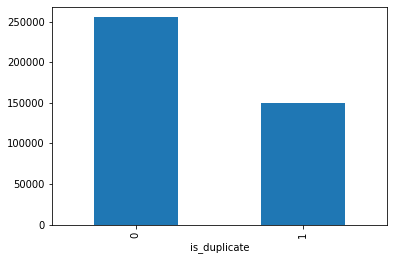

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Total number of question pairs for training:
   404290
~> Question pairs are not Similar (is_duplicate = 0):
   63.08%
~> Question pairs are Similar (is_duplicate = 1):
   36.92%


### 3.2.2 Number of unique questions

In [7]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 

q_vals = qids.value_counts()
q_vals = q_vals.values

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157


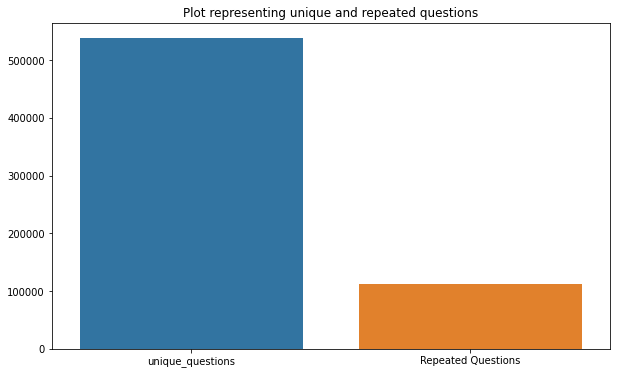

In [8]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions")
sns.barplot(x = x, y = y)
plt.show()

### 3.2.3 Checking for Duplicates

In [9]:
# Checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions", (pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### 3.2.4 Number of occurrences of each question

Maximum number of times a single question is repeated: 157



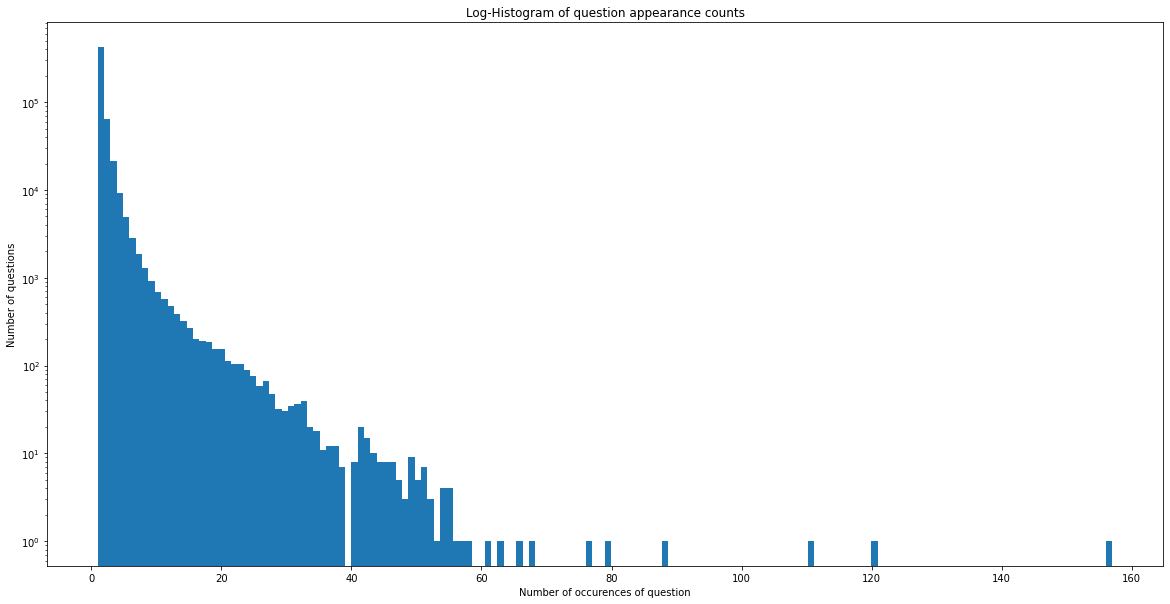

In [10]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonpositive='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

### 3.2.5 Checking for NULL values

In [11]:
# Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [12]:
# There are two rows with null values in question2
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 3.3 Basic Feature Extraction (before cleaning)
Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [13]:
if os.path.isfile('../input/d/elemento/quora-question-pairs/df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("../input/d/elemento/quora-question-pairs/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### 3.3.1 Analysis of some of the extracted features
- Here are some questions have only one single words.

In [14]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


#### 3.3.1.1 Feature: word_share
- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar).
- In our univariate data analysis, we learnt that if for a particular feature, the distributions are completely over-lapping, then it's the worst case.
- And similarly, if the distributions are completely separate, then it's the best case. In our case, we have a got the middle of the both worlds.

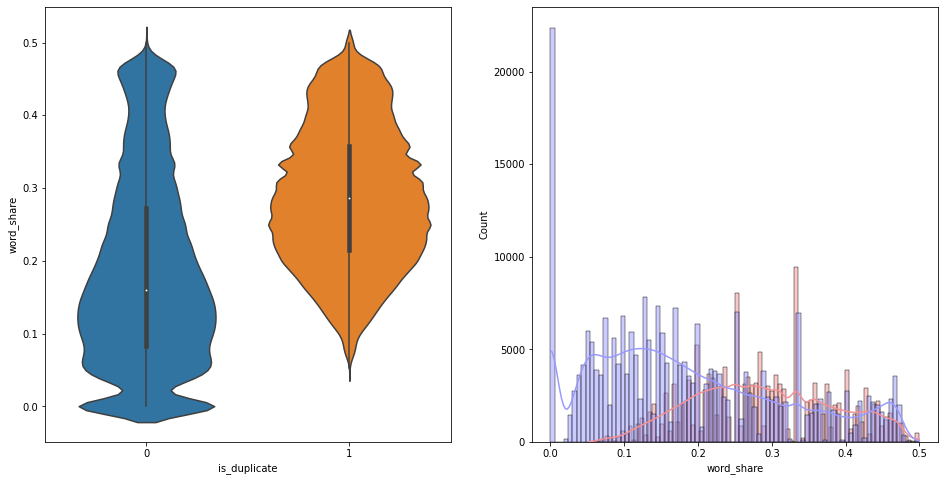

In [15]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , kde = True, label = "1", color = '#f49093')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , kde = True, label = "0" , color = '#9999ff')
plt.show()

#### 3.3.1.2 Feature: word_Common
- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping.
- Now, if we compare the situation of `word_share` and `word_Common` with each other, we will find that the distributions of word_Common are slightly more overlapping than those of word_share, and hence, word_share is slightly a better feature than word_Common.

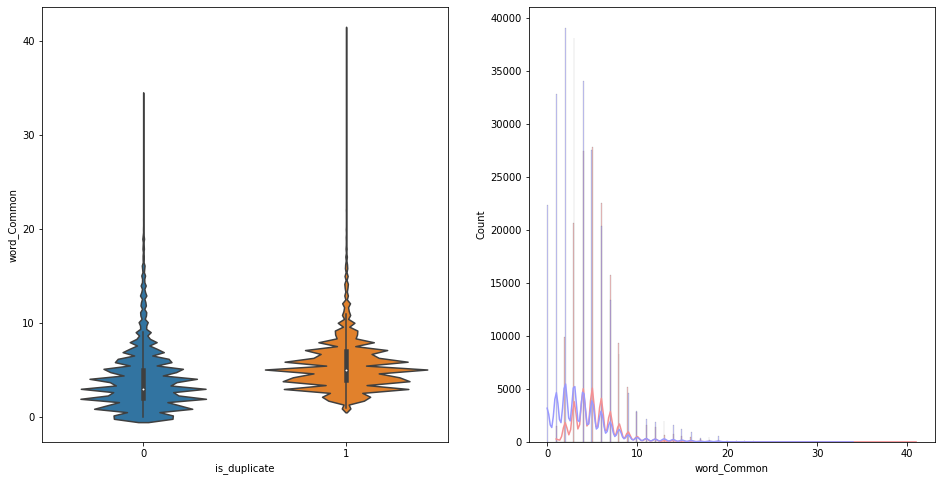

In [16]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , kde = True, label = "1", color = '#f49093')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , kde = True, label = "0" , color = '#9999ff')
plt.show()

## 3.4 Preprocessing of Text
- Preprocessing
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc

In [17]:
# To get the results in 4 decimal points
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
       .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
       .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
       .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
       .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
       .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
       .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

**Function to Compute and get the features : With 2 parameters of Question 1 and Question 2**
## 3.5 Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence with the space character
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
- __last_word_eq__ :  Check if the last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
- __first_word_eq__ :  Check if the first word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage<br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage<br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage<br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage<br>
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [18]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# Get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # Pre-processing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    # Computing Fuzzy Features and Merging with Dataset
    # Do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [19]:
if os.path.isfile('../input/d/elemento/quora-question-pairs/nlp_features_train.csv'):
    df = pd.read_csv("../input/d/elemento/quora-question-pairs/nlp_features_train.csv", encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("data/train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)

df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


### 3.5.1 Analysis of extracted features
#### 3.5.1.1 Plotting Word clouds
- Creating Word Cloud of Duplicate and Non-Duplicate Question pairs
- We can observe the most frequently occuring words in Duplicate Question pairs and Non-Duplicate Question pairs.
- Based on the below word-clouds, we can conclude that there are certain words that occur more frequently in duplicate pair of questions than non-duplicate pair of questions, and vice-versa.
- Also, there are certain words that occur with almost the same frequency, in both duplicate as well as non-duplicate pair of questions.
- These observations suggest that counting the frequency of words could give us an important feature, and we will look at some BoW and TF-IDF based vectorization in the further sections.

In [ ]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

# Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

In [ ]:
# Reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
# stopwords.remove("good")
# stopwords.remove("love")
stopwords.remove("like")
# stopwords.remove("best")
# stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

In [ ]:
# Word Clouds generated from  duplicate pair question's text
plt.figure(figsize = (12, 10))
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Word Clouds generated from non duplicate pair question's text
plt.figure(figsize = (12, 10))
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

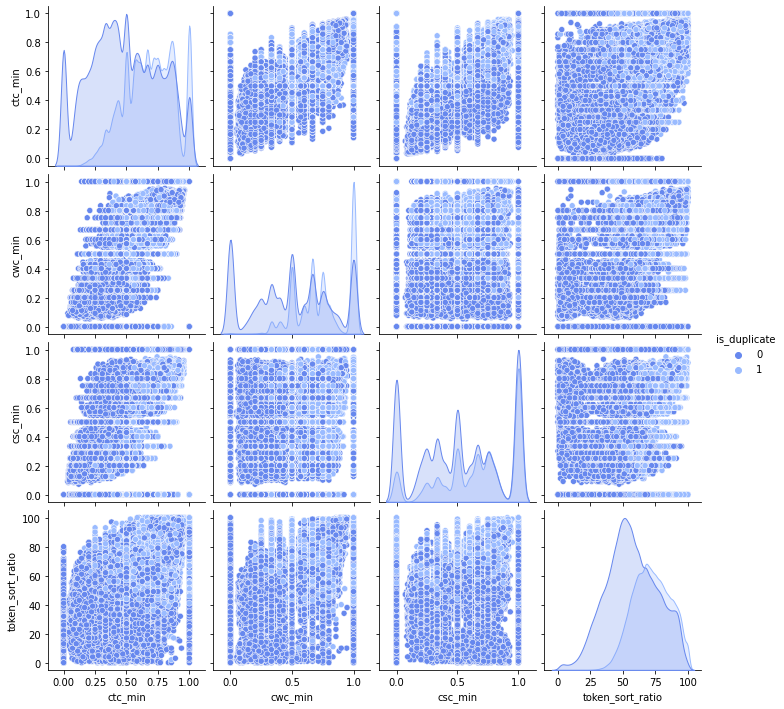

In [25]:
sns.set_palette("coolwarm")
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min','is_duplicate', 'token_sort_ratio']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

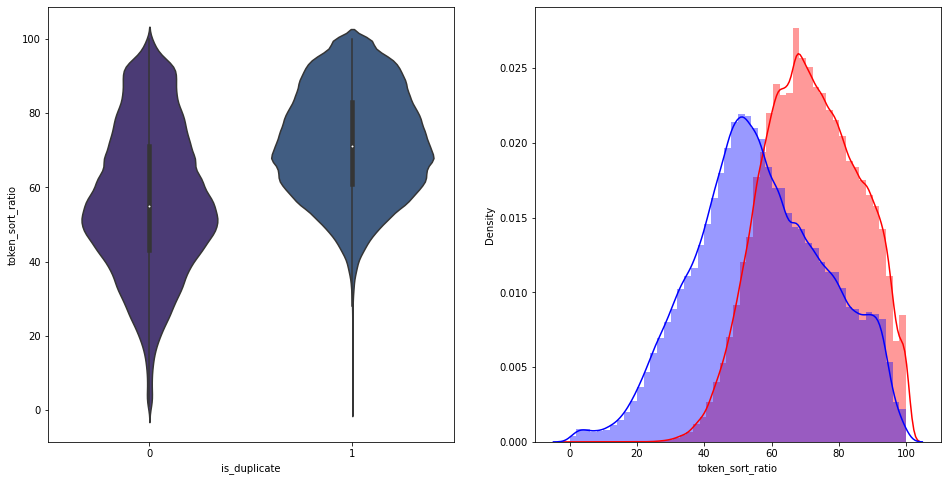

In [23]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

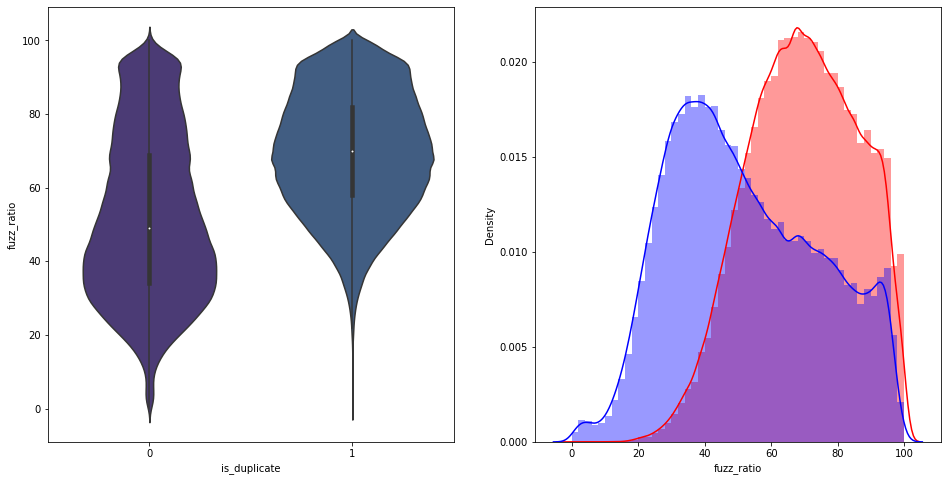

In [24]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### 3.5.2 Visualization

In [28]:
# Using TSNE for Dimentionality reduction for 15 Features 
# (Generated after cleaning the data) to 3 dimensions
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[[
    'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 
    'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',  
    'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']
])
y = dfp_subsampled['is_duplicate'].values

In [29]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.308s
[t-SNE] Iteration 50: error = 80.9720154, gradient norm = 0.0451379 (50 iterations in 1.315s)
[t-SNE] Iteration 100: error = 70.4389801, gradient norm = 0.0098959 (50 iterations in 1.027s)
[t-SNE] Iteration 150: error = 68.6479645, gradient norm = 0.0059423 (50 iterations in 1.034s)
[t-SNE] Iteration 200: error = 67.8050308, gradient norm = 0.0040715 (50 iterations in 1.093s)
[t-SNE] Iteration 250: error = 67.3068771, gradient norm = 0.0031636

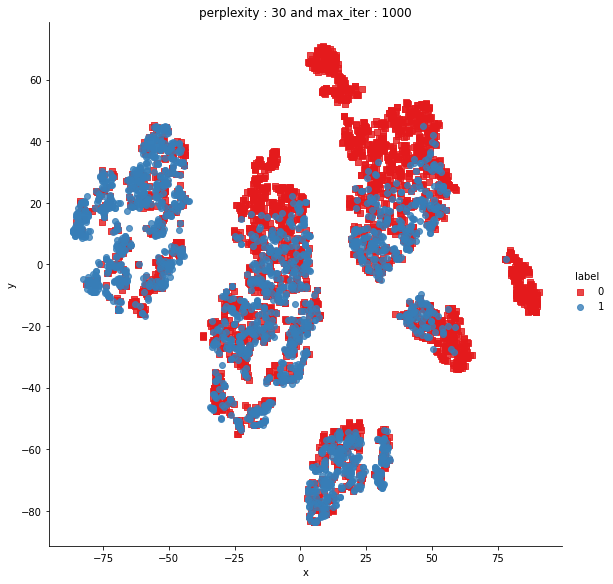

In [30]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# Draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,
   palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [31]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.302s
[t-SNE] Iteration 50: error = 80.3915558, gradient norm = 0.0316218 (50 iterations in 4.984s)
[t-SNE] Iteration 100: error = 69.1343765, gradient norm = 0.0036096 (50 iterations in 2.736s)
[t-SNE] Iteration 150: error = 67.6455231, gradient norm = 0.0017848 (50 iterations in 2.411s)
[t-SNE] Iteration 200: error = 67.0878448, gradient norm = 0.0011522 (50 iterations in 2.393s)
[t-SNE] Iteration 250: error = 66.7604980, gradient norm = 0.0008683

In [32]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## 3.6 Featurizing text data with tfidf weighted word-vectors
- From our previous analysis, we realized that some words occur more often in `class 1` pairs, while some words occur more often in `class 0` pairs.
- So, the question is can we use this realization somehow to construct text-based features? We know both TF-IDF and Word2Vec techniques. However, instead of using W2V, we will be usibg **GLoVE** for this problem.
- GLoVE is very similar to W2V, in that it helps us to convert words into vectors while maintaining the **semantic relationships** among words. The only difference is in the way they work.

In [33]:
# Avoid decoding problems
df = pd.read_csv("../input/quora-question-pairs/train.csv.zip")

# Encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [34]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [35]:
# Merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- Here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [36]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')
vecs1 = []

# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # Word2Vec
        vec1 = word1.vector
        # Fetch df score
        try: idf = word2tfidf[str(word1)]
        except: idf = 0
        # Compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 404290/404290 [52:26<00:00, 128.48it/s]


In [37]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # Word2Vec
        vec2 = word2.vector
        # Fetch df score
        try: idf = word2tfidf[str(word2)]
        except: idf = 0
        # Compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [51:41<00:00, 130.37it/s]


In [38]:
# prepro_features_train.csv (Simple Preprocessing Feartures)
# nlp_features_train.csv (NLP Features)
if os.path.isfile('../input/d/elemento/quora-question-pairs/nlp_features_train.csv'):
    dfnlp = pd.read_csv("../input/d/elemento/quora-question-pairs/nlp_features_train.csv",encoding='latin-1')
else:
    print("Download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('../input/d/elemento/quora-question-pairs/df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("../input/d/elemento/quora-question-pairs/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("Download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

- So, the final feature vector(s) or x_i(s) consists of 4 parts. The 1st part consists of the features provided to us in the original dataset, and the ones we engineered in the **Basic Feature Extraction Section (3.3)**.
- The 2nd part consists of the 15 features that we engineered in the **Advanced Feature Extraction Section (3.5)**.
- The 3rd part consists of the **TF-IDF Weighted GLoVE representation of the Question 1(s)**, and the 4th  part consists of the **TF-IDF Weighted GLoVE representation of the Question 2(s)**.

In [39]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [40]:
# Dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [41]:
# Data before pre-processing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [42]:
# Questions 1 tfidf-weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,78.682992,87.635912,77.898819,-61.473692,44.053226,18.525178,-28.609312,47.452460,-86.095610,58.907952,...,7.157678,86.842601,38.238606,-25.909486,3.169638,-54.031532,-112.663659,1.619508,81.309565,-17.361949
1,99.993008,55.174564,-2.049167,36.677249,85.412371,-45.989080,31.112590,76.453094,-74.456509,110.348369,...,-64.475704,27.344039,-22.471263,-23.111044,-97.185489,13.815928,-24.577477,72.654378,58.654857,-19.836278
2,62.709638,72.489519,10.889310,-45.772860,71.261772,-34.385969,-26.228285,18.224490,-113.496336,115.968702,...,77.008272,5.414788,-26.222928,35.709896,-49.750098,-74.032807,-130.011004,-84.557644,10.153947,-30.314630
3,35.006791,-40.413219,53.450493,-45.069038,37.137247,-21.992808,-28.184323,131.916699,41.891510,27.243861,...,-36.975472,25.987250,-74.511655,-45.798322,42.739461,-17.318146,37.957786,-47.867102,-101.418604,-3.919247
4,135.425154,187.445625,143.612776,-111.735024,56.977977,-70.101866,-47.585533,59.575895,-56.992457,253.326808,...,-34.521699,74.533560,-3.963831,-77.077944,27.673524,-87.661703,-146.777092,1.730535,5.950078,-12.494797


In [43]:
# Questions 2 tfidf-weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,69.938774,62.048677,65.471186,-65.080995,37.007811,11.953720,-44.908971,39.077935,-71.113359,64.970021,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,100.523184,60.707327,114.135677,-2.311834,28.477254,-0.705671,113.688085,117.816506,-93.662698,81.227491,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,28.122773,-0.262905,-8.952834,-14.151883,18.908912,40.142980,62.036967,60.638759,-79.254361,108.044290,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,22.605501,-22.139145,18.226516,-20.430915,22.291252,35.642941,-31.471534,61.818255,-40.677339,33.871990,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,1.158371,29.232888,66.428352,-43.949273,12.497666,6.992168,-57.236839,32.344526,-56.251407,48.231540,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029


In [44]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [45]:
# Storing the final features to CSV file
if not os.path.isfile('../input/d/elemento/quora-question-pairs/final_features_sm.csv'):
    df3_q1['id'] = df1['id']
    df3_q2['id'] = df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features_sm.csv')